In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
tb_max = 58863.34
t_fl = -17.4928

In [4]:
abs_mag_df = pd.read_csv('abs_mag_p48.csv')
abs_mag_df.head(5)

,t_restframe,abs_mag,mag_unc,filt
0,0.779844,-16.127753,0.015658,r
1,0.847793,-15.763070,0.014474,i
2,0.867332,-16.356836,0.010132,g
3,3.731084,-16.089966,0.017258,r
4,3.789436,-15.866692,0.015882,g


In [5]:
models_df = pd.read_csv('../data/models/polin2019/Mtot_0.96/0.92_0.04_doubledet.mag', 
                        delim_whitespace=True, comment='#',
                        names = ['time', 'Lbol', 'Mbol', 
                                    'ZTF_g', 'ZTF_r', 'ZTF_i', 
                                    'uvw2', 'uvm2', 'uvw1', 'u', 'b', 'v'])
models_df.head()

,time,Lbol,Mbol,ZTF_g,ZTF_r,ZTF_i,uvw2,uvm2,uvw1,u,b,v
0,0.05,1.000000e-10,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.15,1.000000e-10,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.25,1.553813e+40,-11.78107,-10.70353,-10.77827,-10.41040,-10.37931,-10.47036,-10.63125,-10.86153,-10.80783,-10.43487
3,0.35,1.052898e+41,-13.85854,-12.41576,-12.26163,-11.90686,-12.37787,-12.50525,-12.39935,-12.68548,-12.59342,-12.22220
4,0.45,3.627155e+41,-15.20149,-13.26546,-13.19983,-12.61924,-13.68696,-13.82780,-13.65307,-13.57273,-13.35879,-13.35785


<IPython.core.display.Javascript object>


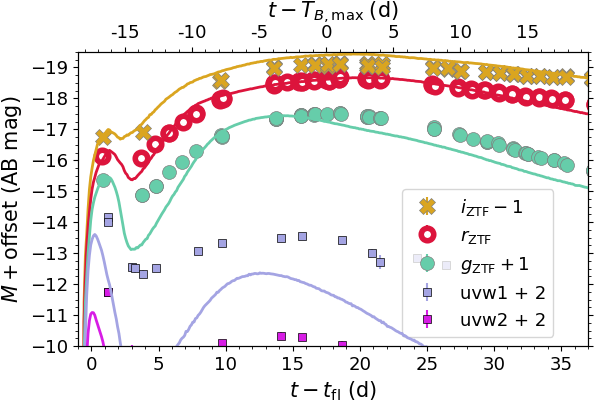

In [18]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 4,
            1: 0.5,
            3: 0.5}
ms_dict = {2: 9,
           1: 10,
           3: 12}
filt_dict = {1:'g', 
             2:'r', 
             3:'i'}
label_dict = {1:r'$g_\mathrm{ZTF} + 1$', 
             2:r'$r_\mathrm{ZTF}$', 
             3:r'$i_\mathrm{ZTF} - 1$'}
zorder_dict = {3: 10,
               1: 5,
               2: 2}
offset_dict = {3: -1,
               1: 1,
               2: 0,
               "uvw2": 4,
               "uvm2": 2,
               "uvw1": 2}

fig, ax = plt.subplots(figsize=(6,4))

for filt in [3,2,1]:
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])
    
    ax.plot(models_df.time.values-0.8, 
            models_df['ZTF_{}'.format(filt_dict[filt])].values + offset_dict[filt], 
            color=color_dict[filt], 
            lw=2, zorder=100)



uvw1_obs = np.where(abs_mag_df.filt == 'UVW1')
ax.errorbar(abs_mag_df.t_restframe.values[uvw1_obs], 
            abs_mag_df.abs_mag.values[uvw1_obs]  + offset_dict['uvw1'], 
            abs_mag_df.mag_unc.values[uvw1_obs],
            fmt = 's', color=color_dict['uvw1'], ecolor=color_dict['uvw1'],
            mec='k', mew=0.5,
            label='uvw1 + 2')
ax.plot(models_df.time.values-0.8, 
        models_df['uvw1'].values  + offset_dict['uvw1'], 
        color=color_dict['uvw1'], 
        lw=2, zorder=100)


uvw2_obs = np.where(abs_mag_df.filt == 'UVW2')
ax.errorbar(abs_mag_df.t_restframe.values[uvw2_obs], 
            abs_mag_df.abs_mag.values[uvw2_obs]  + offset_dict['uvw2'], 
            abs_mag_df.mag_unc.values[uvw2_obs],
            fmt = 's', color=color_dict['uvw2'], ecolor=color_dict['uvw2'],
            mec='k', mew=0.5,
            label='uvw2 + 2')
ax.plot(models_df.time.values-0.8, 
        models_df['uvw2'].values  + offset_dict['uvw2'], 
        color=color_dict['uvw2'], 
        lw=2, zorder=100)


ax.set_ylim(-10, -19.5)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-1, 37)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', right=True, labelsize=13)

ax.legend(loc=4, fontsize=13,
          bbox_to_anchor=(0.95,0,0,0))

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,20,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 20, 41) - t_fl))
ax2.tick_params(labelsize=13)


fig.subplots_adjust(top=0.87,right=0.98,bottom=0.135, left=0.13)
fig.savefig('../paper/figures/double_det.pdf')